In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import json
import re

import random
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LdaModel
from gensim.matutils import Sparse2Corpus
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
stemmer = SnowballStemmer("english")

In [ ]:
# For this homework it may be easier to first load the two monthly
# files into memory (into two different variables)

# Question 1

In [3]:
def isReferenced(text, refList = ['R:C.N', 'R:JPM.N', 'R:BAC.N', 'R:GS.N', 'R:MS.N']):
    return np.any([company in text for company in refList])

In [4]:
def computeQ1Stats(data):

    # How many articles are there in this month?
    articles = [el 
                for el in data["Items"]
                if el["data"]["urgency"] == 3]

    print(f"# of Articles = {len(articles)}")

    # How many of these articles are in English?
    enArticles = [el
                for el in articles
                if el["data"]["language"] == "en"]
    print(f"# of Articles in English = {len(enArticles)}")

    # How many English-language articles in this month reference any of the five companies in their subject field: C.N (Citigroup), JPM.N, BAC.N (Bank of America), GS.N and MS.N?
    refArticles = [el
                for el in enArticles
                if isReferenced(text = el["data"]["subjects"])]

    print(f"# of English-language articles that reference any of [C.N, JPM.N, BAC.N, GS.N, MS.N] in their subject field = {len(refArticles)}")

    return articles, enArticles, refArticles

In [5]:
def getLehmanData(data):
    
    lehArticles = {
        el["data"]["versionCreated"]: (el["data"]["altId"], el["data"]["headline"])
        for el in (data["Items"]) 
        if len(el["data"]["body"]) >= 1800
        and el["data"]["urgency"] == 3
        and el["data"]["language"] == "en"
        and "R:LEH.N" in el["data"]["subjects"]
    }

    df = pd.DataFrame(lehArticles).T.sort_index()
    df.columns = ["altID", "headline"]
    df = df.drop_duplicates(subset=["altID"])
    
    pd.set_option('max_colwidth', 200)
    print(f"# of qualified (>1,800 char) English articles about Lehman Brothers = {len(df)}")
    print('\n')
    
    print("First five articles: ")
    print(df.iloc[:5, 1].to_string())
    
    print('\n')
    print("Last five articles: ")
    print(df.iloc[-5:, 1].to_string())

    return df

In [6]:
def reportQ1Results(ym):
    
    fp =  f"/data/ThomsonReuters_NewsArchive/{ym[:4]}/News.RTRS.{ym}.0214.txt"
    with open(fp, "r") as f:
        print("Loading Data ...")
        data = json.load(f)
        print("Successfully loaded.")
        
    print('\n')
    print(f"REPORT of {ym}")

    print("(1.a-c)")
    computeQ1Stats(data)

    print('\n')
    print("(1.d)")
    getLehmanData(data)

In [7]:
reportQ1Results('200612')

Loading Data ...
Successfully loaded.


REPORT of 200612
(1.a-c)
# of Articles = 168224
# of Articles in English = 98639
# of English-language articles that reference any of [C.N, JPM.N, BAC.N, GS.N, MS.N] in their subject field = 1015


(1.d)
# of qualified (>1,800 char) English articles about Lehman Brothers = 59


First five articles: 
2006-12-01T07:27:34.000Z             Japan CMBS issues seen up 30pct at $21 bln in 2007
2006-12-01T08:34:54.000Z    ANALYSIS-Big investment banks eyeing Japan's commods market
2006-12-01T10:24:06.000Z                   TEXT-Moody's release on Onyx Funding Limited
2006-12-01T11:29:10.000Z         RPT-Institutions seek private equity - Lehman director
2006-12-01T11:49:18.000Z             Weak dollar unwelcome guest at bankers' bonus bash


Last five articles: 
2006-12-20T15:36:10.000Z           Wall St banks eye bigger slice of UK mortgage pie
2006-12-21T12:58:50.000Z    INTERVIEW-Credit Suisse aims to be major player on TOCOM
2006-12-21T23:49:57.000Z  

In [9]:
reportQ1Results('200809')

Loading Data
REPORT of 200809
(1.a-c)
# of Articles = 217391
# of Articles in English = 139742
# of English-language articles that reference any of [C.N, JPM.N, BAC.N, GS.N, MS.N] in their subject field = 4048


(1.d)
# of qualified (>1,800 char) English articles about Lehman Brothers = 1008
First five articles: 
2008-09-01T00:37:25.000Z                PRESS DIGEST - South Korean newspapers - Sept 1
2008-09-01T01:17:04.000Z    UPDATE 1-Lehman in talks with KDB to raise $6 bln-Telegraph
2008-09-01T10:00:43.000Z                       TAKE-A-LOOK-Ongoing major Asia M&A deals
2008-09-02T00:36:04.000Z                PRESS DIGEST - South Korean newspapers - Sept 2
2008-09-02T03:45:02.000Z       UPDATE 1-KDB confirms talks with Lehman on possible deal


Last five articles: 
2008-09-29T20:04:15.000Z           WRAPUP 2-Citigroup buys Wachovia banking; deals abound
2008-09-29T21:08:07.000Z    US CREDIT-Financial debt faces new hurdles on bailout failure
2008-09-30T13:36:29.000Z      TEXT-S&P rel

Comparing articles in December 2006 and September 2008:


(1) In general, the volume of text(articles) data increased.


(2) The number of articles that mentioned Lehman Brothers significantly surged in September 2008 (by 1608.47%).

(3) As only the headlines of these articles are reported, there is no obvious conclusion about the difference of contents in these articles.

# Question 2

https://liaison.reuters.com/tools/topic-codes

In [8]:
def isEM(text, emList = ["N2:BR", "N2:TR", "N2:MX", "N2:ZA"]):
    return np.any([country in text for country in emList])

In [9]:
def getEMSample(data):
    '''
    --------------------------------------------------------------------
    Return the contents of English EM articles
    0: altId
    1: headline   # stores for 2(g)
    2: body 
    --------------------------------------------------------------------
    '''
    
    textList = [[el["data"]["altId"], el["data"]["headline"], el["data"]["body"]] 
    for el in data["Items"]
    if el["data"]["language"] == "en"
    and el["data"]["urgency"] == 3
    and el["data"]["body"] != ''
    and isEM(el["data"]["subjects"])
    ]

    print(f"# of English EM articles = {len(textList)}")

    return textList

In [10]:
def cleanData(text):
    '''
    --------------------------------------------------------------------
    Lowercase, tokenize, drop stop words, stem;
    Construct DTM
    --------------------------------------------------------------------
    '''
    analyzer = CountVectorizer(stop_words = "english").build_analyzer()

    stemmer = SnowballStemmer("english")

    def own_analyzer(docstr):
        return [stemmer.stem(wrd) for wrd in analyzer(docstr)]

    cv = CountVectorizer(analyzer = own_analyzer)
    dtm_raw = cv.fit_transform(text)

    print(f"Shape of DTM = {dtm_raw.shape}")

    return cv, dtm_raw

In [11]:
def wordFrequency(topN, cv, dtm_raw):
    '''
    --------------------------------------------------------------------
    Return the fraction of words in total length
    --------------------------------------------------------------------
    '''
    freq = dtm_raw.sum(axis=0)
    named_freq = [(wrd, freq[0, idx]) for wrd, idx in cv.vocabulary_.items()]
    named_freq = sorted(named_freq, key = lambda x: x[1], reverse = True)
    word_freq = pd.DataFrame(named_freq, columns=["word", "count"]).set_index("word")

    total_occ = word_freq.sum().values[0]
    topN_frac = (word_freq / total_occ).head(topN)

    print("The 25 most frequently occurring tokens in this month:")
    print(word_freq.iloc[:25])

    # plot for topN
    topN_frac.head(100).plot.bar(rot=90, xlabel="Word", ylabel="Fraction", figsize=(20,10), title = f"Top{topN} Words")
    plt.show()

    print(f"Fraction of Top 100 words = {(word_freq.head(100).sum()*100/total_occ).values[0]:.4f}%")
    

    return word_freq

In [12]:
def sentimentScore(cv, dtm_raw) -> tuple:
    '''
    --------------------------------------------------------------------
    Return sentiment scores for each article -> array
    --------------------------------------------------------------------
    '''

    LM = pd.read_csv("./Loughran-McDonald_MasterDictionary_1993-2021.csv")
    pos_list = LM[LM["Positive"]!=0]["Word"].tolist()
    neg_list = LM[LM["Negative"]!=0]["Word"].tolist()

    # LM words are capitalized and unstemmed
    pos_list = [stemmer.stem(wrd) for wrd in pos_list]
    neg_list = [stemmer.stem(wrd) for wrd in neg_list]

    pos_list = list( set(pos_list) )
    neg_list = list( set(neg_list) )


    # index of positive words in articles &L-M dictionary in model output -> list
    pos_words = [cv.vocabulary_[wrd] for wrd in pos_list if cv.vocabulary_.get(wrd, "") != ""]
    neg_words = [cv.vocabulary_[wrd] for wrd in neg_list if cv.vocabulary_.get(wrd, "") != ""]


    t = dtm_raw.sum(axis=1) # number of total words
    p = dtm_raw[:, pos_words].sum(axis=1)
    n = dtm_raw[:, neg_words].sum(axis=1)

    scores = (p - n) / t

    return np.array(scores).squeeze(), pos_words, neg_words

In [13]:
def varianceDecomposition(pos_words, neg_words, cv, dtm_raw):
    '''
    --------------------------------------------------------------------
    Returns the Covariance Matrix
    The variance formula use the score results
    --------------------------------------------------------------------
    '''

    arr_pos = np.nan_to_num((dtm_raw[:, pos_words].sum(axis=1)) / dtm_raw.sum(axis=1)).squeeze()
    arr_neg = np.nan_to_num((dtm_raw[:, neg_words].sum(axis=1)) / dtm_raw.sum(axis=1)).squeeze()

    # arr_pos = ((dtm_raw[:, pos_words].sum(axis=1)) / dtm_raw.sum(axis=1)).squeeze()
    # arr_neg = ((dtm_raw[:, neg_words].sum(axis=1)) / dtm_raw.sum(axis=1)).squeeze()
    arr = np.stack((arr_pos, arr_neg), axis = 0)

    arr = arr - arr.mean(axis=1)
    cov = arr @ arr.T

    print(f"Variation in article sentiment driven by positive words: {cov[0,0]:.4f}")
    print(f"Variation in article sentiment driven by negative words: {cov[1,1]:.4f}")
    
    return cov

In [14]:
def findQ2Headlines(scores, articles, dtm_raw):
    '''
    --------------------------------------------------------------------
    Returns the most negative / positive
    --------------------------------------------------------------------
    '''
    ft = np.where( (dtm_raw.sum(axis = 1) > 300) & (dtm_raw.sum(axis = 1) < 500) )[0]
    df = pd.DataFrame(articles, index=np.arange(len(articles)), columns=["altId", "headline", "body"]).iloc[ft,:]
    df["scores"] = scores[ft]
    df = df.sort_values(by = "scores", ascending = False)

    pd.set_option("max_colwidth", 200)
    print("Top 5 positive articles' headlines")
    print(df.head(5)[["altId", "headline"]].to_string(index = False))
    
    print('\n')
    print("Top 5 negative articles' headlines")
    print(df.tail(5)[["altId", "headline"]].to_string(index = False))
    print('\n')
    print(f"Avergae sentiment score = {np.nanmean(scores):.6f}")

In [15]:
def reportQ2Results(ym):
    
    fp = f"/data/ThomsonReuters_NewsArchive/{ym[:4]}/News.RTRS.{ym}.0214.txt"
    with open(fp, "r") as f:
        print("Loading Data...")
        data = json.load(f)
        print("Successfully loaded.")
    
    print("(2.a)")
    EMs = getEMSample(data)

    print("(2.b-c)")
    cv, dtm_raw = cleanData(textList[2] for textList in EMs)

    print("(2.d")
    freq = wordFrequency(100, cv, dtm_raw)

    print("(2.e)")
    scores, pos_words, neg_words = sentimentScore(cv, dtm_raw)

    print("(2.f)")
    cov = varianceDecomposition(pos_words, neg_words, cv, dtm_raw)

    print("(2.g)")
    hl = findQ2Headlines(scores, EMs, dtm_raw)


Loading Data...
Successfully loaded.
(2.a)
# of English EM articles = 4189
(2.b-c)
Shape of DTM = (4189, 29639)
(2.d
The 25 most frequently occurring tokens in this month:
         count
word          
reuter   15270
said     13158
percent   7222
year      6440
dec       5705
market    5354
com       5135
new       4534
report    4465
price     4350
gold      3975
rate      3682
keyword   3665
bank      3329
news      3289
compani   3274
million   3074
pct       3070
net       3068
trade     3063
south     2953
turkey    2854
mexico    2834
brazil    2732
union     2704


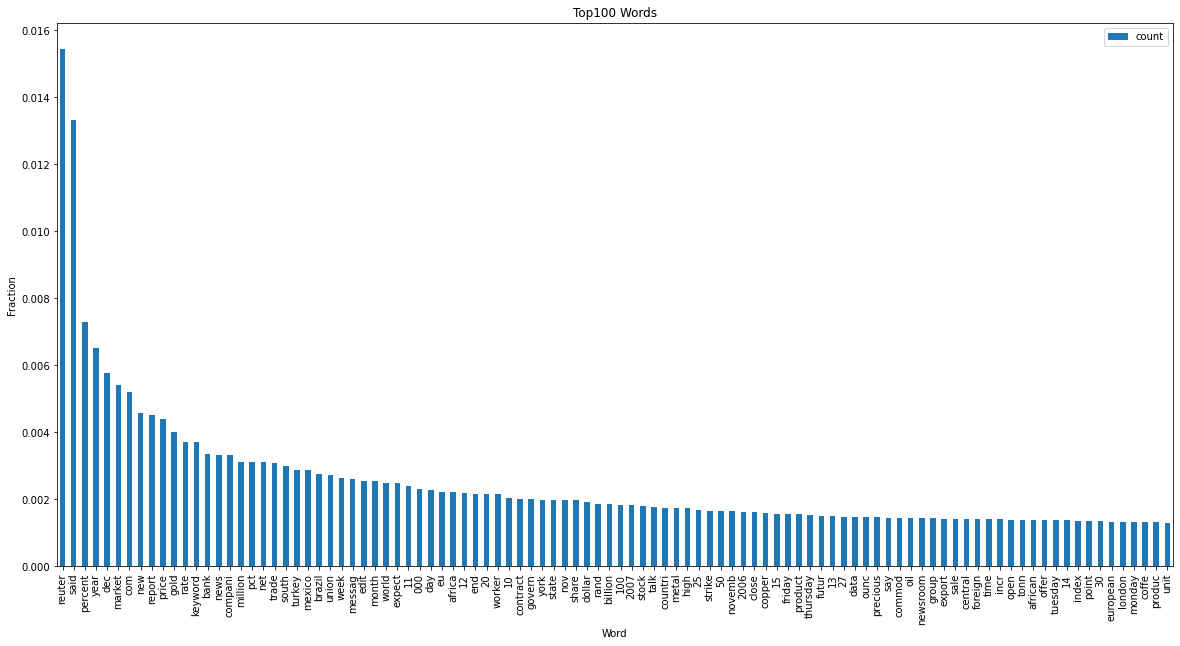

Fraction of Top 100 words = 25.0980%
(2.e)
(2.f)
Variation in article sentiment driven by positive words: 0.7451
Variation in article sentiment driven by negative words: 2.8911
(2.g)
Top 5 positive articles' headlines
     altId                                                       headline
nL05572498      UPDATE 1-S.Africa manufacturing, business confidence jump
  nWNA9059         TEXT-Fitch on Banco UBS Pactual, Pactual Overseas Corp
  nB396367         UPDATE 1-Golf-Woods caps season of triumph and tragedy
  nWNA1490                              TEXT-S&P release on MRS Logistica
  nWLA6717 TEXT-Fitch release on Vestel Elektronik Sanayi ve Ticaret A.S.


Top 5 negative articles' headlines
     altId                                                headline
nPAR964502       FACTBOX-Trials and charges against Saddam Hussein
nL18434461 IMF urges Zimbabwe to cut spending, ensure food imports
nN08373523  UPDATE 2-Two U.S. pilots charged in Brazil plane crash
nN04439570      Oaxaca calm gives

In [16]:
reportQ2Results('200612')

Loading Data...
Successfully loaded.
(2.a)
# of English EM articles = 5212
(2.b-c)
Shape of DTM = (5212, 29385)
(2.d
The 25 most frequently occurring tokens in this month:
         count
word          
reuter   22816
said     13031
com      10044
percent   9975
market    7590
price     6610
year      5982
gold      5542
sept      5393
report    5266
bank      4728
news      4554
pct       4429
keyword   4328
net       4225
10        4208
south     3995
messag    3870
africa    3862
new       3825
rate      3793
11        3600
oil       3345
mexico    3334
trade     3229


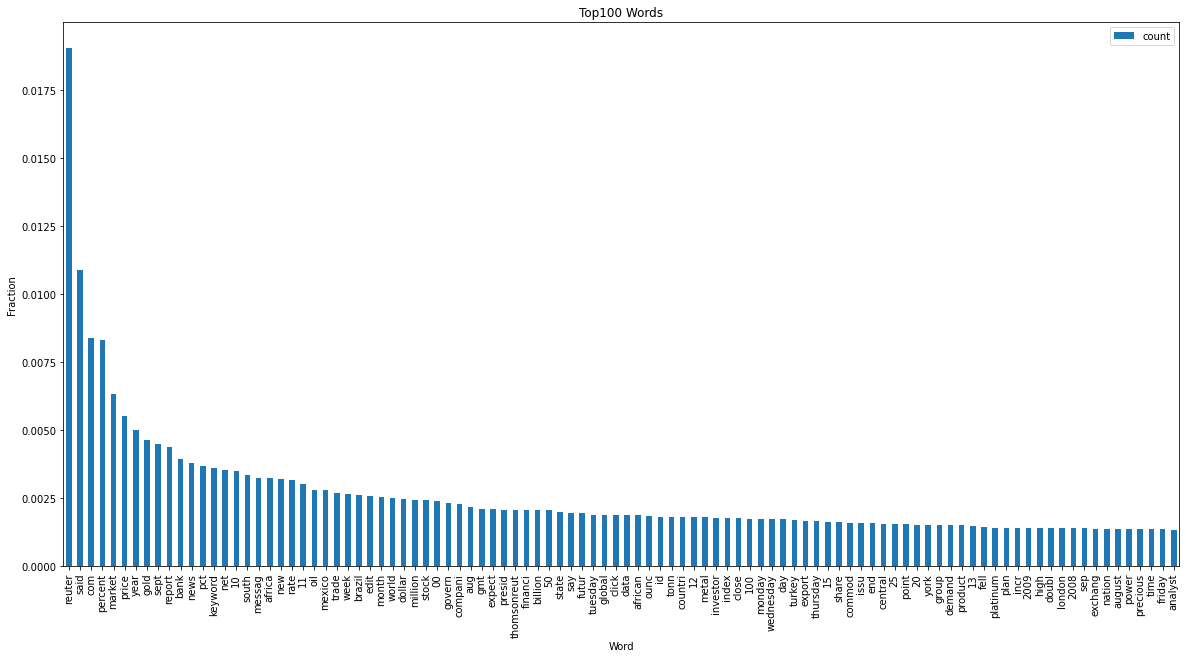

Fraction of Top 100 words = 26.0044%
(2.e)
(2.f)
Variation in article sentiment driven by positive words: 0.9302
Variation in article sentiment driven by negative words: 4.8450
(2.g)
Top 5 positive articles' headlines
    altId                                                  headline
 nWNA3579                    TEXT-Moody's release on Banco Fibra SA
 nLI35786   WRAPUP 1-Soccer-UEFA Cup relief for Milan and Ancelotti
nLN225677 UPDATE 2-INTERVIEW-Petra Diamonds swings to annual profit
 nWNA2986        TEXT-Moody's release on Credito Inmobiliario notes
 nWNA3798                  TEXT-Fitch may raise Brazil's Company SA


Top 5 negative articles' headlines
     altId                                                 headline
 nLB041011 FACTBOX-S.Africa's Zuma seeks dismissal of graft charges
 nLC002351  INSTANT VIEW-Reaction to dismissal of case against Zuma
  nL870722                Media-government tensions flare in Turkey
 nL8672002                Media-government tensions flare in Turk

In [17]:
reportQ2Results('200809')

(1) Average sentiment scores are much lower in 09/2008.


(2) The variation ariation in article sentiment driven by negative words is larger in 09/2008.


Therefore 09/2008 has more negative sentiment of EM articles. It is mainly resulted from the fear of GFC.

# Question 4 Topic Analysis

In [39]:
def isCovidMentioned(text, keyWords = ["covid", "coronavirus"]):
    
    return np.any( [ (re.search(pattern = k, string = text, flags = re.IGNORECASE) is not None) for k in keyWords])


def getQ4Sample(data):

    textList = [
        [el["data"]["headline"],el["data"]["body"]]
        for el in data["Items"]
        if el["data"]["language"] == "en"
        and el["data"]["urgency"] == 3 
        and isCovidMentioned(el["data"]["body"],["covid", "coronavirus"])]
    print("(4.a)")
    print(f"# of articles mention Covid = {len(textList)}")
    return textList

In [19]:
def samplingArticles(data):
    res = []
    for i, dt in enumerate(data):
        if i==0: 
            res = dt
        else:
            res.extend(dt)
    return random.sample(res, 10000)

In [43]:
def nMostFrequent(n, cv, dtm_raw):
    
    # find the 1000 most frequently occurring words
    
    freq = dtm_raw.sum(axis=0)
    
    top_words = [(wrd, idx, freq[0,idx]) for wrd,idx in cv.vocabulary_.items()]
    top_words = sorted(top_words, key = lambda x: x[2], reverse = True)
    top_idx = [el[1] for el in top_words]
    dtm_small = dtm_raw[:,top_idx]
    
    return dtm_small

In [45]:
def trainLDA(cv, dtm_raw):
    
    corpus = Sparse2Corpus(dtm_raw.T)
    lda = LdaModel(corpus, num_topics = 10, id2word={v:k for k,v in cv.vocabulary_.items()})

    print("10-topic model estimation")
    print("20 words in each topic that have the highest topic-word probability:")
    for w in lda.show_topics(num_words = 20):
        print(w, '\n')
    
    return lda

In [23]:
def plotWordCloud(model_LDA, topic_id=[0,1]):
    #  two model estimations ?
    for t in topic_id:
        plt.figure()
        print(f"Topics {t}")
        wc = WordCloud().generate_from_frequencies(dict(model_LDA.show_topic(t, topn=30)))
        plt.imshow(wc)
        
    plt.figure()
    print("Topics Similarity: ")
    sns.heatmap(cosine_similarity(model_LDA.get_topics()))
    plt.plot()

In [42]:
articles = []
for ym in ["202003", "202004"]:
    with open(f'/data/ThomsonReuters_NewsArchive/{ym[:4]}/News.RTRS.{ym}.0214.txt', 'r', encoding='utf-8') as f:
        print("Loading data...")
        try:
            data = json.load(f)
            articles.append(getQ4Sample(data))
            print(f"Successfully loded.")
        except MemoryError:
            print("MemoryError", ym)
            break

print("(4.b)")
articles = samplingArticles(articles)

print("(4.c)")
cv, dtm_raw = cleanData([it[1] for it in articles])

Loading data...
(4.a)
# of articles mention Covid = 80125
Successfully loded.
Loading data...
(4.a)
# of articles mention Covid = 71549
Successfully loded.
(4.b)
(4.c)
Shape of DTM = (10000, 56921)


(4.d)
10-topic model estimation
20 words in each topic that have the highest topic-word probability:
(0, '0.032*"news" + 0.015*"compani" + 0.014*"page" + 0.014*"market" + 0.012*"coronavirus" + 0.010*"global" + 0.009*"bank" + 0.008*"commod" + 0.007*"thomsonreut" + 0.006*"world" + 0.006*"america" + 0.006*"reuter" + 0.006*"africa" + 0.006*"north" + 0.006*"basic" + 0.006*"wealth" + 0.006*"energi" + 0.006*"gas" + 0.005*"rate" + 0.005*"com"') 

(1, '0.027*"news" + 0.013*"page" + 0.012*"market" + 0.011*"compani" + 0.009*"coronavirus" + 0.009*"commod" + 0.007*"china" + 0.007*"reuter" + 0.007*"bank" + 0.007*"global" + 0.006*"north" + 0.006*"new" + 0.006*"africa" + 0.006*"energi" + 0.006*"america" + 0.006*"wealth" + 0.005*"stock" + 0.005*"com" + 0.005*"phone" + 0.005*"gas"') 

(2, '0.018*"said" + 0.012*"reuter" + 0.011*"coronavirus" + 0.008*"com" + 0.007*"report" + 0.006*"thomsonreut" + 0.005*"march" + 0.005*"new" + 0.005*"state" + 0.005*"week" + 0.005*"govern" + 0.004*"peopl" + 0.004*"countri" 

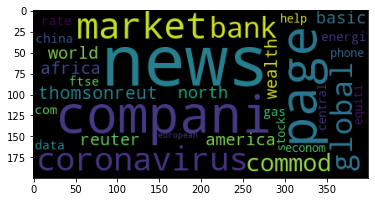

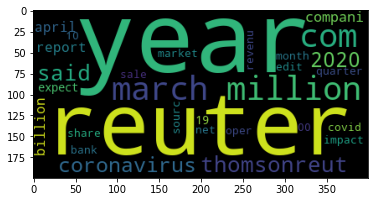

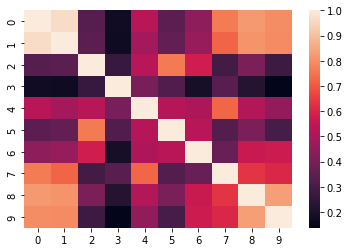

In [46]:
print("(4.d)")
# dtm_small = nMostFrequent(1000, cv, dtm_raw)

model = trainLDA(cv, dtm_raw)

print("(4.e)")
topic_id=[0,5]
plotWordCloud(model, topic_id)

(4.f)
This topic model might be improved by adding more topics because some of the "stupid words" are not excluded and several topics overlaps.
